# Topic Modeling: Latent Semantic Analysis/Indexing

Latent Semantic Analysis set out to improve the results of queries that omitted relevant documents containing synonyms of query terms. Its aimed to model the relationships between documents and terms to be able to predict that a term should be associated with a document, even though, because of variability in word use, no such association was observed.

LSI uses linear algebra to find a given number k of latent topics by decomposing the DTM. More specifically, it uses the Singular Value Decomposition (SVD) to find the best lower-rank DTM approximation using k singular values & vectors. In other words, LSI is an application of the unsupervised learning techniques of dimensionality reduction we encountered in chapter 12 (with some additional detail). The authors experimented with hierarchical clustering but found it too restrictive to explicitly model the document-topic and topic-term relationships or capture associations of documents or terms with several topics.

## Imports & Settings

In [1]:
using Pkg

In [2]:
using PyCall
using Conda

In [3]:
#Pkg.add("Glob")
#Pkg.add("TextAnalysis")
#Pkg.add("DataFrames")
#Pkg.add("Plots")
#Pkg.add("StatsPlots")
#Pkg.add("Random")
#Pkg.add("StringEncodings")
#Pkg.add("ScikitLearn")

In [4]:
using Glob
using TextAnalysis
using DataFrames
using Plots
using StatsPlots
using Seaborn
using StringEncodings
using Random

In [5]:
using ScikitLearn

In [6]:
using ScikitLearn: @sk_import

In [7]:
@sk_import feature_extraction.text: TfidfVectorizer
@sk_import decomposition: TruncatedSVD
@sk_import decomposition: PCA
@sk_import model_selection: train_test_split

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore C:\Users\Amirreza\.julia\packages\ScikitLearn\Kn82b\src\Skcore.jl:169


PyObject <function train_test_split at 0x0000000091F2BDC0>

## Load BBC data

We will illustrate the application of LSI using the BBC articles data that we introduced in the last chapter (13) because they are both small to permit quick training and allow us to compare topic assignments to category labels.

In [8]:
files = Glob.glob("../data/bbc/bbc/**/*.txt")

2225-element Vector{String}:
 "..\\data\\bbc\\bbc\\business\\001.txt"
 "..\\data\\bbc\\bbc\\business\\002.txt"
 "..\\data\\bbc\\bbc\\business\\003.txt"
 "..\\data\\bbc\\bbc\\business\\004.txt"
 "..\\data\\bbc\\bbc\\business\\005.txt"
 "..\\data\\bbc\\bbc\\business\\006.txt"
 "..\\data\\bbc\\bbc\\business\\007.txt"
 "..\\data\\bbc\\bbc\\business\\008.txt"
 "..\\data\\bbc\\bbc\\business\\009.txt"
 "..\\data\\bbc\\bbc\\business\\010.txt"
 "..\\data\\bbc\\bbc\\business\\011.txt"
 "..\\data\\bbc\\bbc\\business\\012.txt"
 "..\\data\\bbc\\bbc\\business\\013.txt"
 ⋮
 "..\\data\\bbc\\bbc\\tech\\390.txt"
 "..\\data\\bbc\\bbc\\tech\\391.txt"
 "..\\data\\bbc\\bbc\\tech\\392.txt"
 "..\\data\\bbc\\bbc\\tech\\393.txt"
 "..\\data\\bbc\\bbc\\tech\\394.txt"
 "..\\data\\bbc\\bbc\\tech\\395.txt"
 "..\\data\\bbc\\bbc\\tech\\396.txt"
 "..\\data\\bbc\\bbc\\tech\\397.txt"
 "..\\data\\bbc\\bbc\\tech\\398.txt"
 "..\\data\\bbc\\bbc\\tech\\399.txt"
 "..\\data\\bbc\\bbc\\tech\\400.txt"
 "..\\data\\bbc\\bbc\\tech\\

In [9]:
doc_list = Any[]
for (i,file) in enumerate(files)
    f = open(file,"r")
    s = StringDecoder(f,"LATIN1", "UTF-8")
    topic = split(file, "\\")[end-1]
    lines = readlines(s)
    heading = strip(lines[1])
    body = strip(join([strip(line) for line in lines[2:end]]))
    push!(doc_list, [uppercasefirst(topic), heading, body])
    close(s)
    close(f)
end

### Convert to DataFrame

In [10]:
docs = DataFrame(Category = [String(x[1]) for x in doc_list], Heading = [String(x[2]) for x in doc_list], Article = [String(x[3]) for x in doc_list])
first(docs, 5)

,Category,Heading,Article
,String,String,String
1,Business,Ad sales boost Time Warner profit,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake."
2,Business,Dollar gains on Greenspan speech,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""Worries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's policy have fallen on deaf ears, despite recent co

## Create Train & Test Sets

We begin by loading the documents and creating a train and (stratified) test set with 50 articles. Then, we vectorize the data using the TfidfVectorizer to obtain weighted DTM counts and filter out words that appear in less than 1% or more than 25% of the documents as well as generic stopwords to obtain a vocabulary of around 2,900 words:

In [11]:
#Pkg.add("Pandas")
using Pandas

In [12]:
pd_docs = Pandas.DataFrame(docs)
pd_train_docs, pd_test_docs = train_test_split(pd_docs,
                                         stratify=pd_docs.Category,
                                         test_size=50,
                                         random_state=42)

2-element Vector{PyObject}:
 PyObject            Category  ...                                            Article
568   Entertainment  ...  Sky has signed a major new deal to broadcast t...
1970           Tech  ...  A campaign by Lycos Europe to target spam-rela...
526   Entertainment  ...  Dame Muriel Spark is among three British autho...
488        Business  ...  Traders at US banking giant Citigroup are faci...
1313          Sport  ...  British hurdler Sarah Claxton is confident she...
...             ...  ...                                                ...
1231       Politics  ...  Tony Blair has told Labour supporters he's "ba...
935        Politics  ...  Jack Straw has attacked the decision by Britai...
1783          Sport  ...  Jennifer Capriati has become the third leading...
664   Entertainment  ...  A box set featuring 68 unreleased Nirvana trac...
1039       Politics  ...  An MP has had more than Â£600 and his passport...

[2175 rows x 3 columns]
 PyObject            Cate

In [13]:
train_docs = DataFrames.DataFrame(Category = [category for category ∈ pd_train_docs.Category], 
    Heading = [heading for heading ∈ pd_train_docs.Heading], 
    Article = [article for article ∈ pd_train_docs.Article])

,Category,Heading,Article
,String,String,String
1,Entertainment,Sky takes over Oscar night mantle,"Sky has signed a major new deal to broadcast this year's Academy Awards, taking over from three years of live Oscar coverage on the BBC.Sky said it was ""honoured to have won exclusive broadcasting rights"" and promised to cover the event ""in a way no other broadcaster could"". The BBC denied it had lost a bidding war, saying it had ""decided to pass the mantle to another broadcaster"". The ceremony, hosted by newcomer Chris Rock, takes place on 27 February 2005.Sky's coverage will launch with the nominations on 25 January and will include themed programming across Sky channels including Sky News, Sky Travel and the Biography Channel. There will also be a month-long season of Oscar-winning films on Sky Movies in the run up to the event and live uninterrupted coverage on the night. ""We are honoured to have won the live and exclusive broadcasting rights for The Academy Awards,"" said Sky Networks' Sophie Turner Laing. ""Sky is the natural place to see the biggest and most prestigious film event of the year, and will cover the event in a way that no other broadcaster could.""Sky first scooped Oscar rights from the BBC in 1999, but the BBC won them back in 2001 when Sky was forced to pull out of a bidding war due to financial constraints. ""BBC viewers will of course be able to watch quality coverage of the 2005 Academy Awards on the BBC's bulletins and news programmes,"" a spokesman said. Among the films tipped to do well at this year's Academy Awards are Martin Scorsese's The Aviator, Jean-Pierre Jeunet's A Very Long Engagement and the Ray Charles biopic, Ray."
2,Tech,Freeze on anti-spam campaign,"A campaign by Lycos Europe to target spam-related websites appears to have been put on hold.Earlier this week the company released a screensaver that bombarded the sites with data to try to bump up the running costs of the websites. But the site hosting the screensaver now displays a pink graphic and the words ""Stay tuned"". No one at Lycos was available for comment on latest developments in its controversial anti-spam campaign.Lycos Europe's ""Make love not spam"" campaign was intended as a way for users to fight back against the mountain of junk mail flooding inboxes. People were encouraged to download the screensaver which, when their PC was idle, would then send lots of data to sites that peddle the goods and services mentioned in spam messages. Lycos said the idea was to get the spam sites running at 95% capacity and generate big bandwidth bills for the spammers behind the sites. But the plan has proved controversial.Monitoring firm Netcraft analysed response times for some of the sites targeted by the screensaver and found that a number were completely knocked offline.The downing of the sites could dent Lycos claims that what it is doing does not amount to a distributed denial of service attack. In such attacks thousands of computers bombard sites with data in an attempt to overwhelm them. Laws in many countries do not explicitly outlaw such attacks but many nations are re-drafting computer use laws to make them specific offences. Lycos Europe now appears to have put the plan on hold. The site hosting the screensaver currently shows a holding page, with the words, ""Stay tuned"". The numerical internet address of the site has also changed. This is likely to be in response to spammers who have reportedly redirected traffic from their sites back to the Lycos screensaver site. The campaign has come under fire from some corners of the web. Many discussion groups have said that it set a dangerous precedent and could incite vigilantism. ""Attacking a spammer's website is like poking a grizzly bear sleeping in your back garden with a pointy stick,"" said Graham Cluley, senior technology consultant for Sophos. ""Not only is this screensaver similar in its approach to a potentially illegal distributed denial of service attack, but it also

In [14]:
test_docs = DataFrames.DataFrame(Category = [category for category ∈ pd_test_docs.Category], 
    Heading = [heading for heading ∈ pd_test_docs.Heading], 
    Article = [article for article ∈ pd_test_docs.Article])

,Category,Heading,Article
,String,String,String
1,Entertainment,Animation charms Japan box office,"Oscar-winning director Hayao Miyazaki's latest film has set a new Japanese box office record, with 1.5bn yen ($14.3m) in two days, according to reports.Howl's Moving Castle is the follow-up to Miyazaki's Spirited Away, which won best animation at last year's Oscars. It is based on the children's book by English writer Diana Wynne Jones. It has registered the highest opening weekend takings of any Japanese film in the country, according to trade publication Screen Daily.The film is about an 18-year-old girl who is trapped in an old woman's body after being put under a spell by a witch. Its two-day takings represented 1.1 million cinema admissions, Screen Daily said. The film's distributor Toho expects 40 million people to see it in total - almost one third of the country's population - it added. The film won the Golden Osella for outstanding technical contribution at this year's Venice Film Festival."
2,Tech,Satellite mapping aids Darfur relief,"Aid workers trying to house, feed and clothe millions of homeless refugees in the Sudanese region of Darfur are getting a helping hand from advanced mapping technology.A European consortium of companies and university groups known as Respond is working to provide accurate and up to date maps. The aim is to overcome some of the huge logistical challenges in getting supplies to where they are needed. Respond is using satellite imagery to produce accurate maps that can be used in the field rapidly. ""Respond has produced very detailed maps for example for the road networks, for the rivers and for the villages, to more large-scale maps useful for very general planning purposes,"" said Einar Bjorgo from Unosat, the UN satellite mapping organisation that is part of the Respond consortium.The group uses satellites from Nasa, the European Space Agency and the Disaster Monitoring Constellation. The satellite data is transmitted to ground stations. From there, the information makes its way to Respond organisations that specialise in interpreting such data. ""You have to convert the data into images, then the interpreter has to convert all this into crisis, damage, or situation maps,"" said Stefan Voigt, who works in the remote sensing department of one of those organisations, the German Aerospace Centre.This kind of detailed analysis usually takes a couple of months but Respond gets it done in about 12 hours. ""Our users are usually not so much familiar with reading satellite imagery, reading satellite maps, so it's our task to transfer the data into information that non-technical people can read and understand easily and very, very efficiently,"" said Mr Voigt. Respond supplies maps to aid groups via the web, and on compact disc. But the best map is one you can hold in your hands, especially in remote areas where internet connections and laptops are scarce. ""A map is a working document,"" explains Herbert Hansen of Respond's Belgian partner Keyobs. ""You need to use it, you need to write on it, correct, give feedback and so on, so you need paper to write on. ""We print maps, we laminate the maps, we encapsulate the maps if needed so you can take a shower with the map, it's completely protected.""Humanitarian groups in Darfur have been making good use of Respond's maps. They have come in especially handy during Sudan's rainy season, when normally dry riverbeds, or wadis, became flooded. ""These wadis had a very small amount of flooding, generally, in terms of depth, but greatly impeded the transport capabilities and capacities of the humanitarian groups on the ground,"" says Stephen Candillon of Respond imaging partner Sertit. Respond's rapid imaging has allowed aid groups to find ways around the wadis, allowing then to mark on their maps which roads were washed out at which times. Aid groups say that combination of satellite technology and on-the-ground observation helped keep relief flowing to th

In [15]:
size(train_docs), size(test_docs)

((2175, 3), (50, 3))

In [16]:
value_counts(df, col) = combine(DataFrames.groupby(df, col), nrow)

sort!(value_counts(test_docs, :Category), :nrow, rev=true)

,Category,nrow
,String,Int64
1,Sport,12
2,Business,11
3,Entertainment,9
4,Tech,9
5,Politics,9


### Vectorize train & test sets

In [17]:
vectorizer = TfidfVectorizer(max_df=0.25, min_df=0.01, stop_words="english", binary=false)

train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

PyObject <2175x2916 sparse matrix of type '<class 'numpy.float64'>'
	with 209943 stored elements in Compressed Sparse Row format>

In [18]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

PyObject <50x2916 sparse matrix of type '<class 'numpy.float64'>'
	with 4757 stored elements in Compressed Sparse Row format>

### Get token count

In [19]:
train_token_count = sum.(eachcol(train_dtm.todense()))
tokens = vectorizer.get_feature_names()
word_count = DataFrame(tokens = tokens, count = train_token_count)
sort!(word_count, :count, rev = true)
first(word_count, 10)

C:\Users\Amirreza\.julia\conda\3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tokens,count
,String,Float64
1,film,41.2658
2,government,38.8086
3,game,36.3832
4,best,36.1329
5,uk,36.0871
6,labour,32.5012
7,music,30.6996
8,000,30.2782
9,company,29.5626


## Latent Semantic Analysis

We use sklearn’s TruncatedSVD class that only computes the k largest singular values to reduce the dimensionality of the document-term matrix. The deterministic arpack algorithm delivers an exact solution but the default ‘randomized’ implementation is more efficient for large matrices. 

We compute five topics to match the five categories, which explain only 5.4% of the total DTM variance so higher values would be reasonable.

In [20]:
n_components = 5
topic_labels = ["Topic " * string(i) for i ∈ 1:n_components]

5-element Vector{String}:
 "Topic 1"
 "Topic 2"
 "Topic 3"
 "Topic 4"
 "Topic 5"

In [21]:
svd = TruncatedSVD(n_components=n_components, n_iter=5, random_state=42)
svd.fit(train_dtm)

PyObject TruncatedSVD(n_components=5, random_state=42)

In [22]:
svd.singular_values_

5-element Vector{Float64}:
 8.910103370517142
 5.717481211745645
 5.381483113890275
 5.045674842051183
 4.713951100971166

In [23]:
sum(svd.explained_variance_ratio_)

0.053826374206534494

### Explore Topics 

LSI identifies a new orthogonal basis for the document-term matrix that reduces the rank to the number of desired topics. 

The `.transform()` method of the trained svd object projects the documents into the new topic space that is the result of reducing the dimensionality of the document vectors and corresponds to the UTΣT transformation explained in the book.

In [24]:
train_doc_topics = svd.transform(train_dtm)

2175×5 Matrix{Float64}:
 0.139513  -0.0721822  -0.0109696     0.162114    -0.018709
 0.161377   0.0355757  -0.0994634    -0.027673     0.176324
 0.138225  -0.0649887   0.000870189   0.0982002   -0.0455118
 0.184587   0.0578767  -0.0782788    -0.0446741   -0.0917928
 0.170216  -0.115413    0.0746647    -0.0341978   -0.0527525
 0.150466   0.0511776  -0.0792929    -0.0353337   -0.0297752
 0.178239   0.103166    0.0123117    -0.0110277   -0.0480951
 0.232497   0.0964224   0.0714162     0.0106169    0.053207
 0.133023   0.0623389  -0.118742     -0.0650395   -0.139382
 0.234961  -0.0884092  -0.12585       0.00505431   0.0208205
 0.259637   0.0902536  -0.115496     -0.0854886   -0.210216
 0.13579   -0.106483    0.0750391    -0.0879439    0.0047777
 0.181554   0.183622    0.135464      0.0622751    0.0156607
 ⋮                                                
 0.182143   0.0448016  -0.153785     -0.054874     0.0835541
 0.18558    0.0373658  -0.0075764    -0.042447    -0.0501512
 0.222073  -0.2

In [25]:
size(train_doc_topics)

(2175, 5)

#### Topic Weights for sample article

We can sample an article to view its location in the topic space. We draw a ‘Politics’ article that is most (positively) associated with topics 1 and 2 (and 3):

In [26]:
i = shuffle(1:nrow(train_docs))[1]
sample_train_doc = DataFrame()
sample_train_doc[!, "index"] = [i]
sample_train_doc = hcat(sample_train_doc, DataFrame(train_docs[i, 1:2]))

,index,Category,Heading
,Int64,String,String
1,688,Sport,Kenya lift Chepkemei's suspension


In [27]:
for (j,topic_label) in enumerate(topic_labels)
    sample_train_doc[!, topic_label] = [train_doc_topics[i, j]]
end

DataFrames.show(sample_train_doc, allcols=true)

1×8 DataFrame
│ Row │ index │ Category │ Heading                           │ Topic 1  │
│     │ Int64 │ String   │ String                            │ Float64  │
├─────┼───────┼──────────┼───────────────────────────────────┼──────────┤
│ 1   │ 688   │ Sport    │ Kenya lift Chepkemei's suspension │ 0.175921 │

│ Row │ Topic 2    │ Topic 3   │ Topic 4    │ Topic 5   │
│     │ Float64    │ Float64   │ Float64    │ Float64   │
├─────┼────────────┼───────────┼────────────┼───────────┤
│ 1   │ -0.0770898 │ 0.0614625 │ -0.0570434 │ -0.051551 │

#### Average topic weight per category

In [28]:
train_result = DataFrame()
train_result[!, :Category] = train_docs.Category
train_result = hcat(train_result, rename!(DataFrame(train_doc_topics), topic_labels))
first(train_result, 10)

,Category,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Entertainment,0.139513,-0.0721822,-0.0109696,0.162114,-0.018709
2,Tech,0.161377,0.0355757,-0.0994634,-0.027673,0.176324
3,Entertainment,0.138225,-0.0649887,0.000870189,0.0982002,-0.0455118
4,Business,0.184587,0.0578767,-0.0782788,-0.0446741,-0.0917928
5,Sport,0.170216,-0.115413,0.0746647,-0.0341978,-0.0527525
6,Business,0.150466,0.0511776,-0.0792929,-0.0353337,-0.0297752
7,Politics,0.178239,0.103166,0.0123117,-0.0110277,-0.0480951
8,Politics,0.232497,0.0964224,0.0714162,0.0106169,0.053207
9,Business,0.133023,0.0623389,-0.118742,-0.0650395,-0.139382


In [29]:
mean_topic = by(train_result, :Category,
                "Topic 1" => mean,
                "Topic 2" => mean,
                "Topic 3" => mean,
                "Topic 4" => mean,
                "Topic 5" => mean)
rename!(mean_topic, append!(["Category"], topic_labels))

,Category,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Entertainment,0.171038,-0.0878806,-0.0187621,0.16897,-0.0275086
2,Tech,0.190145,-0.0114773,-0.125906,-0.0123631,0.144663
3,Business,0.18437,0.0631171,-0.0982829,-0.052101,-0.115826
4,Sport,0.17722,-0.14237,0.0969731,-0.0900207,-0.010525
5,Politics,0.210598,0.148897,0.114249,0.0285891,0.0311417


In [30]:
mean_topic = DataFrames.stack(mean_topic, names(mean_topic)[2:6])

,Category,variable,value
,String,Cat…,Float64
1,Entertainment,Topic 1,0.171038
2,Tech,Topic 1,0.190145
3,Business,Topic 1,0.18437
4,Sport,Topic 1,0.17722
5,Politics,Topic 1,0.210598
6,Entertainment,Topic 2,-0.0878806
7,Tech,Topic 2,-0.0114773
8,Business,Topic 2,0.0631171
9,Sport,Topic 2,-0.14237


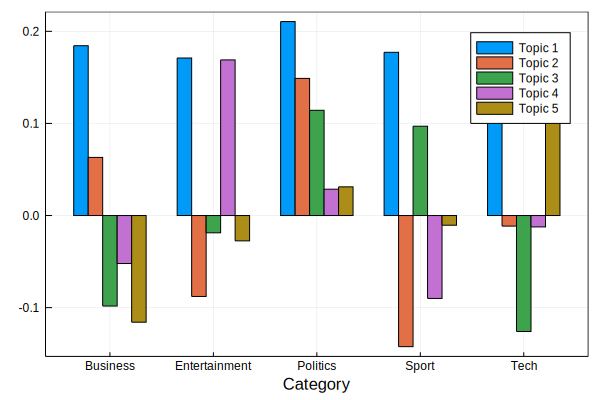

In [31]:
@df mean_topic groupedbar(:Category, :value, group = :variable, xlabel = "Category",
        bar_width = 0.7, framestyle = :box)

#### Topics weights of most frequent words

In [32]:
topics = DataFrame()
topics[!, "tokens"] = tokens
topics = hcat(topics, rename!(DataFrame(transpose(svd.components_)), topic_labels))

,tokens,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,000,0.073354,0.0301494,-0.0448263,0.00320435,-0.0135903
2,000m,0.00831415,-0.0142964,0.00997554,-0.00486066,-0.00707117
3,10,0.052787,-0.00992789,-0.0204954,-0.000303005,-0.0152851
4,100,0.0246822,0.00763008,-0.0116961,-0.000973355,0.00383153
5,100m,0.00858989,-0.00721062,0.00106946,-0.00069513,-0.00760516
6,11,0.0290734,-0.00960399,-0.0119689,0.0194954,-0.0234034
7,12,0.0330621,-0.00956552,-0.0171083,-0.00498418,-0.0179496
8,120,0.00519548,0.000854777,-0.00565851,-0.00152267,0.00376925
9,13,0.0208595,-0.0154438,-0.00277863,0.00172078,-0.0163059


In [33]:
filter(row -> row.tokens ∈ first(word_count, 10).tokens, topics)

,tokens,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,000,0.073354,0.0301494,-0.0448263,0.00320435,-0.0135903
2,best,0.0881385,-0.148765,0.0187205,0.265012,-0.0919023
3,company,0.0676904,0.0241524,-0.102083,-0.0286386,-0.0533842
4,film,0.0961348,-0.157814,-0.0377612,0.456717,-0.108233
5,game,0.0926504,-0.166152,0.07465,-0.113137,0.0563239
6,government,0.105798,0.15857,0.0506916,0.000577247,-0.0319563
7,labour,0.100147,0.237866,0.227163,0.0719322,0.0547026
8,music,0.0787689,-0.0501553,-0.114408,0.0806066,0.140237
9,number,0.0701413,-0.0397709,-0.0194847,0.0302838,0.0035991


#### Most important words by topic

We can also display the words that are most closely associated with each topic (in absolute terms). The topics appear to capture some semantic information but are not clearly differentiated

In [34]:
top_words = DataFrames.DataFrame()
top_vals = DataFrames.DataFrame()
for topic_label ∈ topic_labels
    top = sort!(DataFrames.select(topics, ["tokens", topic_label]), topic_label, rev=true)[1:10, :]
    top_words = hcat(top_words, rename!(DataFrames.select(top, :tokens), [topic_label]))
    top_vals = hcat(top_vals, DataFrames.select(top, topic_label))
end

In [35]:
top_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,String,String,String,String
1,government,labour,labour,film,mobile
2,labour,election,election,best,music
3,film,blair,blair,awards,technology
4,game,party,party,award,users
5,uk,government,brown,actor,software
6,best,brown,england,actress,phone
7,election,tax,howard,oscar,digital
8,blair,minister,win,festival,microsoft
9,music,chancellor,prime,films,phones


In [36]:
top_vals

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,Float64,Float64,Float64,Float64,Float64
1,0.105798,0.237866,0.227163,0.456717,0.179431
2,0.100147,0.200449,0.182054,0.265012,0.140237
3,0.0961348,0.176897,0.181261,0.181945,0.13774
4,0.0926504,0.161601,0.160321,0.165571,0.137473
5,0.0924235,0.15857,0.142661,0.131398,0.132005
6,0.0881385,0.14416,0.10848,0.120886,0.12774
7,0.0855905,0.121872,0.0945637,0.116099,0.120266
8,0.0796312,0.110401,0.091982,0.11277,0.109763
9,0.0787689,0.100929,0.0909098,0.111256,0.098561


In [37]:
convert(Array, top_vals[1, :])

5-element Vector{Float64}:
 0.10579795664678837
 0.23786627861357634
 0.22716272755049413
 0.45671738816074303
 0.17943123355248877

In [38]:
top_vals_series = [convert(Array, top_vals[row, :]) for row ∈ 1:nrow(top_vals)]
top_words_series = [convert(Array, top_words[row, :]) for row ∈ 1:nrow(top_words)]

10-element Vector{Vector{String}}:
 ["government", "labour", "labour", "film", "mobile"]
 ["labour", "election", "election", "best", "music"]
 ["film", "blair", "blair", "awards", "technology"]
 ["game", "party", "party", "award", "users"]
 ["uk", "government", "brown", "actor", "software"]
 ["best", "brown", "england", "actress", "phone"]
 ["election", "tax", "howard", "oscar", "digital"]
 ["blair", "minister", "win", "festival", "microsoft"]
 ["music", "chancellor", "prime", "films", "phones"]
 ["party", "prime", "minister", "director", "computer"]

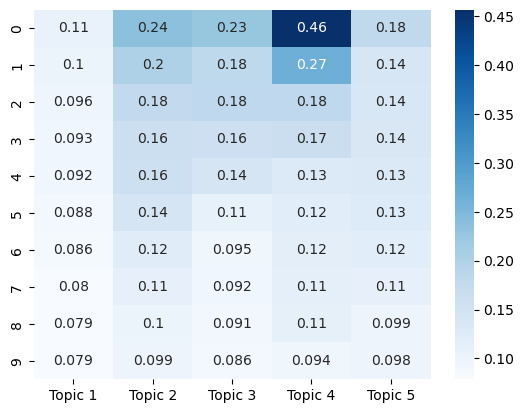

In [39]:
Seaborn.heatmap(top_vals_series, annot=true, cmap="Blues", xticklabels=topic_labels);

#### Topics weights for test set

The topic assignments for this sample align with the average topic weights for each category illustrated below (Politics is the leftmost). They illustrate how LSI expresses the k topics as directions in a k-dimensional space (below you find a projection of the average topic assignments per category into two-dimensional space). 

Each category is clearly defined, and the test assignments match with train assignments. However, the weights are both positive and negative, making it more difficult to interpret the topics.

In [40]:
test_eval = DataFrame()
test_eval[!, :Category] = test_docs.Category
test_eval = hcat(test_eval, rename!(DataFrame(svd.transform(test_dtm)), topic_labels))
first(test_eval, 10)

,Category,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Entertainment,0.193471,-0.140828,-0.0440101,0.3317,-0.103078
2,Tech,0.14023,0.0118663,-0.0613095,-0.01738,0.0794031
3,Tech,0.202408,0.0267403,-0.161138,-0.0380477,0.205189
4,Business,0.150049,0.0434084,-0.0847216,-0.0375455,-0.0741359
5,Sport,0.146961,-0.0754089,0.0525603,-0.0787822,-0.0111063
6,Business,0.221171,-0.0746439,-0.00221909,-0.0863323,-0.0413709
7,Business,0.237273,0.08034,-0.12783,-0.06925,-0.134919
8,Sport,0.198682,-0.218105,0.153514,-0.160702,-0.0210379
9,Business,0.188797,0.0930496,-0.121549,-0.0828019,-0.195047


In [41]:
train_result[!, :Data] .= "Train"
test_eval[!, :Data] .= "Test"
result = vcat(train_result, test_eval)
result = DataFrames.stack(result, names(result)[2:6])
result

,Category,Data,variable,value
,String,String,Cat…,Float64
1,Entertainment,Train,Topic 1,0.139513
2,Tech,Train,Topic 1,0.161377
3,Entertainment,Train,Topic 1,0.138225
4,Business,Train,Topic 1,0.184587
5,Sport,Train,Topic 1,0.170216
6,Business,Train,Topic 1,0.150466
7,Politics,Train,Topic 1,0.178239
8,Politics,Train,Topic 1,0.232497
9,Business,Train,Topic 1,0.133023


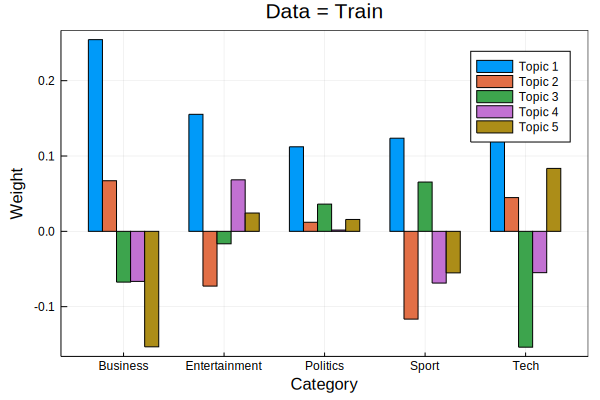

In [42]:
@df result[result.Data .== "Train", :] groupedbar(:Category, :value, group = :variable, xlabel = "Category", ylabel = "Weight",
        title = "Data = Train", bar_width = 0.7, framestyle = :box)

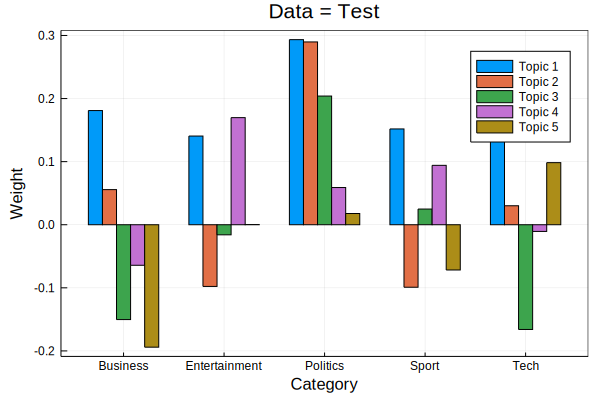

In [43]:
@df result[result.Data .== "Test", :] groupedbar(:Category, :value, group = :variable, xlabel = "Category", ylabel = "Weight",
        title = "Data = Test", bar_width = 0.7, framestyle = :box)

### Categories in 2D

The below plot shows the projections of the five topics into a 2D space.

In [44]:
pca = PCA(n_components=2)

PyObject PCA(n_components=2)

In [48]:
pca_train_result = pca.fit_transform(Pandas.DataFrame(train_result[:, topic_labels]))
svd2d = DataFrames.DataFrame(pca_train_result)
rename!(svd2d, ["PC1", "PC2"])
svd2d[!, :Category] = sort(train_docs.Category)
svd2d

,PC1,PC2,Category
,Float64,Float64,String
1,-0.0694107,-0.00682899,Business
2,0.0378909,-0.0969711,Business
3,-0.062179,0.0043799,Business
4,0.0619811,-0.0765149,Business
5,-0.106571,0.0821097,Business
6,0.0519312,-0.0793857,Business
7,0.109491,0.0117284,Business
8,0.111009,0.0753816,Business
9,0.0593415,-0.12102,Business


In [49]:
categories_2d = by(svd2d, :Category,
                "PC1" => mean,
                "PC2" => mean)
rename!(categories_2d, ["Category", "PC1", "PC2"])

,Category,PC1,PC2
,String,Float64,Float64
1,Business,-0.00284272,-0.000334827
2,Entertainment,-0.00478242,0.00594023
3,Politics,-0.00271937,0.00423796
4,Sport,0.00524098,-0.00174167
5,Tech,0.00437689,-0.00748056


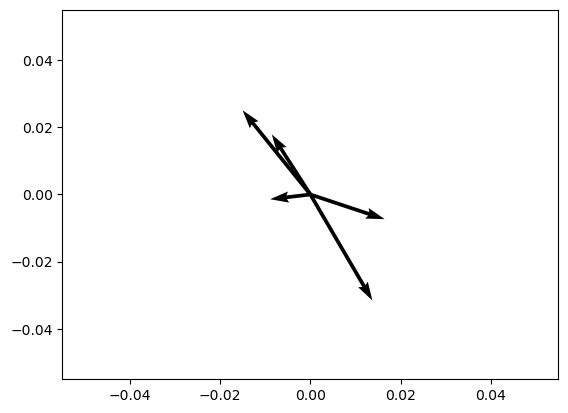

In [50]:
Seaborn.quiver([0 for i ∈ 1:5],
                [0 for i ∈ 1:5],
                values(categories_2d.PC1),
                values(categories_2d.PC2),
                scale=0.035);

## Strenghts & Weaknesses

The benefits of LSI include the removal of noise and mitigation of the curse of dimensionality, while also capturing some semantics and performing a clustering of both documents and terms.

However, the results of LSI are difficult to interpret because topics are word vectors with both positive and negative entries. In addition, there is no underlying model that would permit the evaluation of fit and provide guidance when selecting the number of dimensions or topics.